In [1]:
# import torch
# import random
import numpy as np

# torch.manual_seed(1337)
# torch.cuda.manual_seed(1337)
# np.random.seed(1337)
# random.seed(1337)

import os
from run import Run
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KDTree
import cv2
from copy import deepcopy

/root/anaconda3/envs/towel37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Visualizer:
    # get datapath & get id
    def __init__(self, datapath=None):
        self.datapath = datapath
        self.ids = [self.get_id(f) for f in os.listdir(self.datapath) if "rgb_" in f]
    
    def get_id(self, fname):
        return fname.split('_')[1].replace(".png", "")    

    def outer_inner_corresp(self, i=None):
        depth = np.load(os.path.join(self.datapath, "%s_depth.npy" % i))
        # variance = np.load(os.path.join(self.datapath, "%s_variance.npy" % i))
        green = Image.open(os.path.join(self.datapath, "%s_labels_green.png" % i))
        yellow = Image.open(os.path.join(self.datapath, "%s_labels_yellow.png" % i))
        red = Image.open(os.path.join(self.datapath, "%s_labels_red.png" % i))
        seg = np.stack([red, yellow, green], axis=-1)
        im_height, im_width, _ = seg.shape
        
        # Set regions of overlapping masks to 0
        seg[np.logical_and(seg[:,:,1]==255, seg[:,:,2]==255),2] = 0
        seg[np.logical_and(seg[:,:,1]==255, seg[:,:,2]==255),1] = 0
        
        # Get outer-inner edge correspondence
        xx, yy =  np.meshgrid([x for x in range(im_width)],
                              [y for y in range(im_height)])
        xx_o = xx[seg[:,:,1]==255]
        yy_o = yy[seg[:,:,1]==255]

        inner_edges_mask = np.ones((im_height, im_width))
        inner_edges_mask[seg[:,:,2]==255] = 0
        dists, lbl = cv2.distanceTransformWithLabels(inner_edges_mask.astype(np.uint8), cv2.DIST_L2, 
                                                     5, labelType=cv2.DIST_LABEL_PIXEL)

        # lbl provides at each pixel the index label of        val_sum_path = os.path.join(self.model_path, "summaries", "val", self.run_id) the closest zero point. 
        # Now we find the pixel coordinate of that index label
        inner_pxs = np.where(inner_edges_mask==0)
        xx_inner = inner_pxs[1] # x coords of inner edges
        yy_inner = inner_pxs[0] # y coords of inner edges
        labels_to_pxs = [[0, 0]] # fix off by one offset
        for j in range(len(yy_inner)):
            labels_to_pxs.append([yy_inner[j],xx_inner[j]])
        labels_to_pxs = np.array(labels_to_pxs)
        closest_inner_px = labels_to_pxs[lbl]
        
        # Visualize a fraction of the correspondences as arrows
        # factor = 20
        # plt.figure(dpi=150)
        # plt.imshow(seg)
        # plt.quiver(xx_o[::factor], yy_o[::factor], 
        #            closest_inner_px[yy_o[::factor], xx_o[::factor]][:,1]-xx_o[::factor], 
        #            -closest_inner_px[yy_o[::factor], xx_o[::factor]][:,0]+yy_o[::factor], 
        #            color='orange', scale_units='xy', scale=1.0)
        
        # Calculate distance to the closest inner edge point for every pixel in the image
        dist_to_inner = np.zeros(closest_inner_px.shape)
        dist_to_inner[:,:,0] = np.abs(closest_inner_px[:,:,0]-yy)
        dist_to_inner[:,:,1] = np.abs(closest_inner_px[:,:,1]-xx)
        
        # Normalize distance vectors
        mag = np.linalg.norm([dist_to_inner[:,:,0],dist_to_inner[:,:,1]],axis = 0)+0.00001
        dist_to_inner[:,:,0] = dist_to_inner[:,:,0]/mag
        dist_to_inner[:,:,1] = dist_to_inner[:,:,1]/mag

        # For every outer edge point, find its closest K neighbours 
        num_neighbour = 100
        outer_idxs = np.vstack([xx_o,yy_o])
        try:
            tree = KDTree(outer_idxs.T, leaf_size=2)
        except Exception as e:
            return 0, 0, 0, 0, 0, None, None, None
        if num_neighbour > xx_o.shape[0]:
            return 0, 0, 0, 0, 0, None, None, None
        dist, ind = tree.query(outer_idxs.T, k=num_neighbour)
        
        dist_to_inner_o = dist_to_inner[seg[:,:,1]==255,:]
        xx_neighbours = dist_to_inner_o[ind][:,:,1]
        yy_neighbours = dist_to_inner_o[ind][:,:,0]
        xx_var = np.var(xx_neighbours,axis = 1)
        yy_var = np.var(yy_neighbours,axis = 1)
        var = xx_var+yy_var
        var = var / var.max()
        # var = (var - var.min()) / (var.max() - var.min())
        var_map = np.zeros((im_height, im_width))
        for i in range(xx_o.shape[0]): # xx_o is flat
            var_map[yy_o[i]][xx_o[i]] = var[i]
        
        invvar = 1.0 - var # get inverse
        # pvar = invvar / np.sum(invvar)
        pvar = invvar
        pvar_map = np.zeros((im_height, im_width))
        for i in range(xx_o.shape[0]): # xx_o is flat
            pvar_map[yy_o[i]][xx_o[i]] = pvar[i]
        
        plt.figure()
        plt.subplots_adjust(top=1.5, right=1.5)
        plt.subplot(121)
        plt.imshow(var_map, vmin=var_map.min(), vmax=var_map.max())
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("New var: %0.5f %0.5f" % (var_map.min(), var_map.max()))
        
        plt.subplot(122)
        # plt.imshow(pvar_map, vmin=0.0, vmax=1.0)
        plt.imshow(pvar_map, vmin=pvar_map.min(), vmax=pvar_map.max())
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("New inv var: %0.5f %0.5f" % (pvar_map.min(), pvar_map.max()))
        plt.show()
        
        # np.save("/home/jianingq/Downloads/newvar.npy", pvar_map)

    # sample the dataset from index 1, 10, 100
    def sample_dataset(self):
        for i in [1, 10, 100]:
            rgb = Image.open(os.path.join(self.datapath, "rgb_%s.png" % i))
            depth = np.load(os.path.join(self.datapath, "%s_depth.npy" % i))
            max_d = np.nanmax(depth)
            depth[np.isnan(depth)] = max_d
            
            gt_map = np.load(os.path.join(self.datapath, "%s_inverse_variance.npy" % i))
            
            plt.imshow(rgb)
            plt.show()
            plt.imshow(depth)
            plt.show()
            plt.imshow(gt_map)
            plt.show()

    def seg_output(self, i=None, model=None):
        # get rgb & depth
        rgb = Image.open(os.path.join(self.datapath, "rgb_%s.png" % i))
        depth = np.load(os.path.join(self.datapath, "%s_depth.npy" % i))
        max_d = np.nanmax(depth)
        depth[np.isnan(depth)] = max_d

        # get green yellow red labels
        green = Image.open(os.path.join(self.datapath, "%s_labels_green.png" % i))
        yellow = Image.open(os.path.join(self.datapath, "%s_labels_yellow.png" % i))
        red = Image.open(os.path.join(self.datapath, "%s_labels_red.png" % i))
        
        # stack the three grayscale images along the last dimension. output a rgb image.
        im_gt = np.stack([red, yellow, green], axis=-1)

        yellow_npy = np.asarray(yellow)
        mask = np.zeros_like(yellow_npy, dtype=np.float32)
        mask[yellow_npy > 254] = 1.0
        
        if model == None: 
            print("model == None")
            return
        # numpy.ndarray
        # model.pred.shape: (1, 255, 243, 3)
            # batch_size, height, witdth, channel，这里应该是去掉了batch_size维度
        out = model.evaluate(depth).squeeze()
        print("seg_out.shape:", out.shape)
        seg_pred = out[:, :, :3]
        print("seg_pred.shape:", seg_pred.shape)
        
        # thresholding
        seg_pred_th = deepcopy(seg_pred)
        seg_pred_th[seg_pred_th < 0.8] = 0.0
        
        enable_plt = True

        if enable_plt:  
            plt.figure(dpi=300)

            plt.subplot(141)
            plt.title("rgb")
            plt.imshow(rgb)
            plt.axis("off")

            plt.subplot(142)
            plt.title("seg_pred_0")
            plt.imshow(seg_pred[..., 0])
            plt.axis("off")

            plt.subplot(143)
            plt.title("seg_pred_1")
            plt.imshow(seg_pred[..., 1])
            plt.axis("off")

            plt.subplot(144)
            plt.title("seg_pred_2")
            plt.imshow(seg_pred[..., 2])
            plt.axis("off")
            
            # plt.tight_layout()
            plt.show()
        else:
            print("decide to save image.")

    def var_output(self, i=None, model=None):
        # get rgb_i.png & i_depth.npy
        rgb = Image.open(os.path.join(self.datapath, "rgb_%d.png" % i))
        depth = np.load(os.path.join(self.datapath, "%d_depth.npy" % i))
        max_d = np.nanmax(depth)
        depth[np.isnan(depth)] = max_d
        
        # get i_labels_yellow.png
        yellow = Image.open(os.path.join(self.datapath, "%d_labels_yellow.png" % i))
        yellow_npy = np.asarray(yellow)
        mask = np.zeros_like(yellow_npy, dtype=np.float32)
        mask[yellow_npy > 254] = 1.0
        
        # get i_inverse_variance.npy
        gt_map = np.load(os.path.join(self.datapath, "%d_inverse_variance.npy" % i)).astype(np.float32)
        gt_map[yellow_npy < 255] = 0.0
        print(os.path.join(self.datapath, "%d_inverse_variance.npy" % i))
        
        var_pred = model.evaluate(depth).squeeze()
        var_pred_masked = deepcopy(var_pred)

        print("var_pred_masked.shape: ", var_pred_masked.shape)
        print("mask.shape: ", mask.shape)

        var_pred_masked_channel1 = var_pred_masked[:,:,0]

        # var_pred_masked *= mask
        var_pred_masked_channel1 *= mask
        
        plt.figure(dpi=300)
        plt.subplot(141)
        plt.title("rgb")
        plt.imshow(rgb)
        plt.axis("off")
        plt.subplot(142)
        plt.title("gt invvar")
#         plt.imshow(gt_map, vmin=0.0, vmax=1.0)
        plt.imshow(gt_map)
#         plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")
        plt.subplot(143)
        plt.title("model raw")
        plt.axis("off")
        plt.imshow(var_pred, vmin=0.0, vmax=1.0)
#         plt.colorbar()
        plt.subplot(144)
        plt.title("model masked")
        # Chimy test
        # plt.imshow(var_pred_masked, vmin=0.0, vmax=1.0)
        plt.imshow(var_pred_masked_channel1, vmin=0.0, vmax=1.0)

        plt.colorbar(fraction=0.046, pad=0.04)
#         plt.tight_layout()
        plt.axis("off")
        plt.show()


use my train:  False
in init & load model, self.n_features = 3
________Begin seg process________
seg_out.shape: (255, 243, 3)
seg_pred.shape: (255, 243, 3)


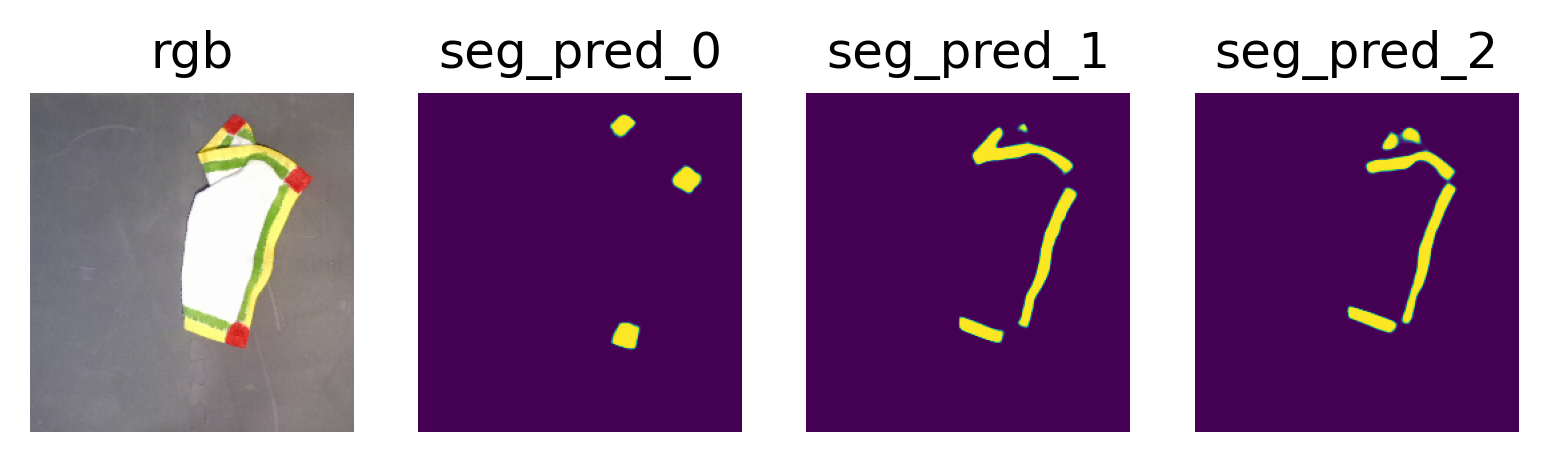

________End   seg process________


In [3]:
# t = Run(model_path=pretrained_model, n_features=3)
# v = Visualizer(datapath)
# v.seg_output(i=0, model=t)

model_id = 2
epoch = 60

my_train = False

# default model param & n_features == 1:
    # size mismatch for final.weight: 
        # copying a param with shape torch.Size([3, 16, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 16, 1, 1]).
    # size mismatch for final.bias: 
        # copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([1]).
# default model param & n_features == 3:
    # 没有出现上述报错
    # Unexpected key(s) in state_dict: 
        # "fc1.0.weight", "fc1.0.bias", 
        # "fc1.1.weight", "fc1.1.bias", "fc1.1.running_mean", "fc1.1.running_var", "fc1.1.num_batches_tracked", 
        # "fc2.0.weight", "fc2.0.bias", 
        # "fc2.1.weight", "fc2.1.bias", "fc2.1.running_mean", "fc2.1.running_var", "fc2.1.num_batches_tracked", 
        # "fc3.0.weight", "fc3.0.bias". 
        # 解决方法：self.model.load_state_dict(torch.load(self.model_path), strict=False)
    # var_pred_masked *= mask
    # ValueError: operands could not be broadcast together with shapes (255,243,3) (255,243) (255,243,3)
        # 通道数不匹配，3-channel和1-channel之间需要转换，但是转换关系目前还不清晰，mask应该如何更新成适用default model的

print("use my train: ", my_train)

if my_train:
    pretrained_model = "/home/chimy/old_projects/cloth-segmentation-main/runspath/%d/chkpnts/%d_epoch%d" % (model_id, model_id, epoch)
else:
    pretrained_model = "/home/chimy/old_projects/cloth-segmentation-main/runspath/pretrained_weights"

datapath = "/home/chimy/old_projects/cloth-segmentation-main/data_painted_towel"

t1 = Run(model_path=pretrained_model, n_features=3)

v1 = Visualizer(datapath)

# Options we can select:
enbale_var = False
enbale_seg = True

if enbale_var:
    print("________Begin var process________")
    v1.var_output(i=1473, model=t1)
    print("________End   var process________")
if enbale_seg:
    print("________Begin seg process________")
    v1.seg_output(i = 1248, model = t1)
    print("________End   seg process________")

# v1.sample_dataset()

# i: rgb_6994.png
# v1.outer_inner_corresp(i = 6994)
# v1.var_output(i = 132, model = t1)  # 测试没成功
# v1.sample_dataset()